In [1]:
import os

import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns

from REStats.utils import load_SCADA, filter_outliers
from REStats.plots import save_figs

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt = load_SCADA(2020)

In [5]:
wt_train = wt[["wind_speed", "power"]]
wt_train = wt_train.resample("H").mean()
wt_train.head()

,wind_speed,power
Date,,
2020-01-01 00:00:00,3.867503,145.013856
2020-01-01 01:00:00,5.663008,411.687777
2020-01-01 02:00:00,4.896892,253.356735
2020-01-01 03:00:00,5.320999,266.979956
2020-01-01 04:00:00,4.438020,155.545291


In [6]:
def filter_outliers(group):
    q1 = group.power.quantile(.25)
    q3 = group.power.quantile(.75)
    iqr = q3 - q1
    filtered = group.query('(@q1 - 1.5 * @iqr) <= power <= (@q3 + 1.5 * @iqr)')
    return filtered
    
wt_bins = np.arange(0, 25, .5)
wt_groups = wt_train.groupby(pd.cut(wt_train.wind_speed, wt_bins))
wt_filtered = wt_groups.apply(filter_outliers)
wt_filtered.index = wt_filtered.index.droplevel()
wt_filtered = wt_filtered.sort_index()
wt_filtered.head()

,wind_speed,power
Date,,
2020-01-01 00:00:00,3.867503,145.013856
2020-01-01 01:00:00,5.663008,411.687777
2020-01-01 02:00:00,4.896892,253.356735
2020-01-01 03:00:00,5.320999,266.979956
2020-01-01 04:00:00,4.438020,155.545291


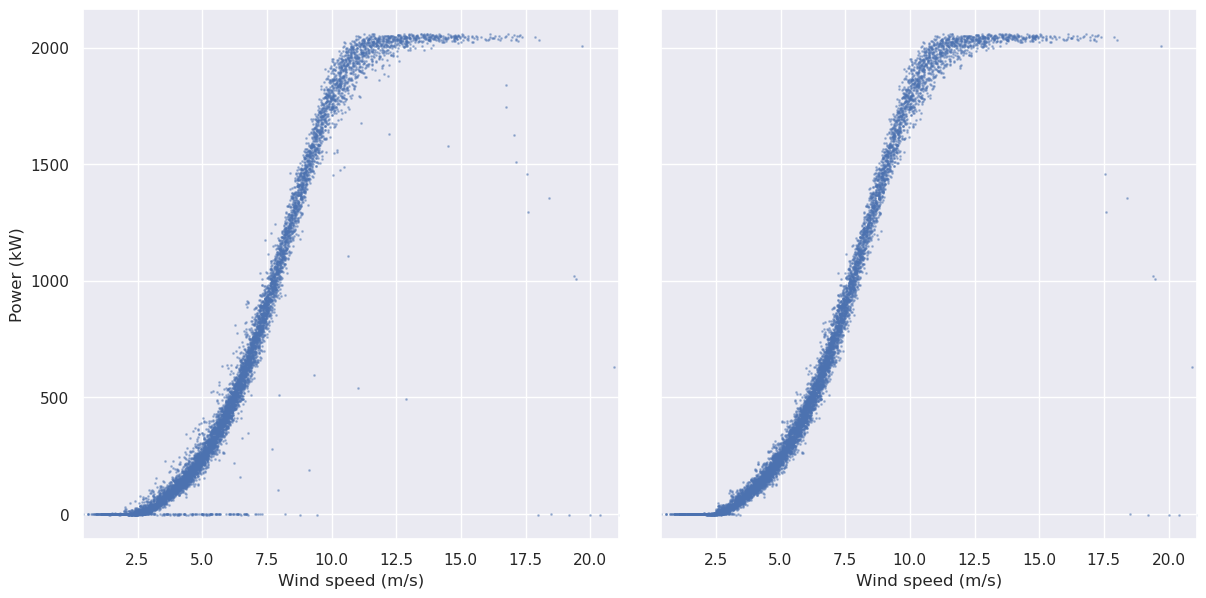

In [7]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].scatter(wt_train.wind_speed, wt_train.power, s=1, alpha=0.4)
axes[1].scatter(wt_filtered.wind_speed, wt_filtered.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

In [8]:
wt.head()

,power,wind_dir,wind_speed
Date,,,
2020-01-01 00:00:00,150.984141,116.839462,3.887291
2020-01-01 00:10:00,130.414782,115.659361,3.848941
2020-01-01 00:20:00,146.401656,116.646515,4.043625
2020-01-01 00:30:00,84.296224,111.157642,3.330342
2020-01-01 00:40:00,94.994105,116.678227,3.388536


In [9]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_filtered.wind_speed.to_numpy()[:, None])

train, _ = train_test_split(wt_filtered, stratify=bins, train_size=200, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train

,wind_speed,power,power_std
Date,,,
2020-03-17 21:00:00,10.313802,1889.864137,1.713874
2020-06-05 21:00:00,7.192982,782.263158,0.062877
2020-09-15 05:00:00,4.187165,130.262967,-0.908999
2020-08-13 23:00:00,5.056633,342.518867,-0.592609
2020-08-28 19:00:00,11.515199,1962.488615,1.822128
...,...,...,...
2020-12-26 18:00:00,14.384422,2040.373539,1.938224
2020-04-20 04:00:00,6.487785,572.539142,-0.249739
2020-04-30 00:00:00,6.565804,636.385494,-0.154569


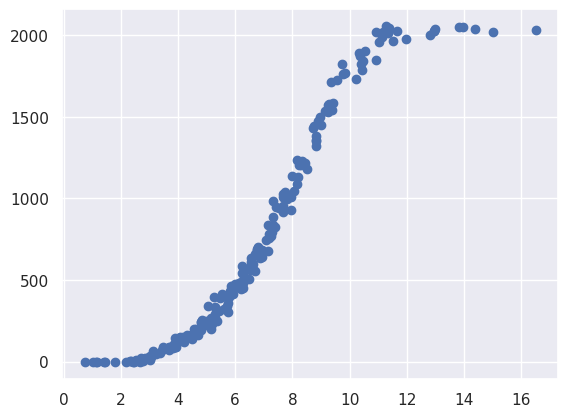

In [10]:
plt.scatter(train.wind_speed, train.power)

In [11]:
X_prior = np.linspace(0, 18, 500)[:, None]

with pm.Model() as model_prior:                    
    ℓ = pm.Gamma("ℓ", 4, 1)
    η = pm.HalfCauchy("η", 1.5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    gp = pm.gp.Latent(cov_func=cov_func)
        
    sigma = pm.HalfNormal("sigma", 1)
    
    f = gp.prior("f", X=X_prior)
    
    idata_pc_prior = pm.sample_prior_predictive(samples=10, random_seed=1)

Sampling: [f_rotated_, sigma, η, ℓ]


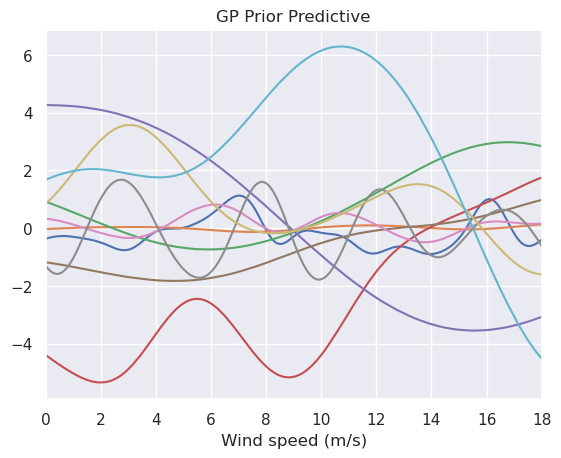

In [12]:
gp_prior, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_title("GP Prior Predictive")
ax.set_xlabel("Wind speed (m/s)")

gp_ppc = idata_pc_prior.prior.f.mean(["chain"])

for gp_y in gp_ppc:
    ax.plot(X_prior, gp_y)
    
figs["gp_prior"] = gp_prior

In [13]:
idata_pc_prior

Inference data with groups:
	> prior

In [14]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", 4, 2)
    η = pm.HalfCauchy("η", 1)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    sigma = pm.HalfNormal("sigma", 1)
    
    y_ = gp.marginal_likelihood("y", X=train.wind_speed[:, None], y=train.power_std.values, sigma=sigma)
    
    idata_pc = pm.sample(chains=2, cores=1)


/tmp/ipykernel_24980/3030435318.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_ = gp.marginal_likelihood("y", X=train.wind_speed[:, None], y=train.power_std.values, sigma=sigma)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 573 seconds.


In [15]:
Xnew = np.linspace(0, 20, 100)[:, None]

with model:
    fnew = gp.conditional("fnew", Xnew=Xnew)

In [16]:
with model:
    pm.sample_posterior_predictive(idata_pc, var_names=["fnew"], extend_inferencedata=True)

Sampling: [fnew]


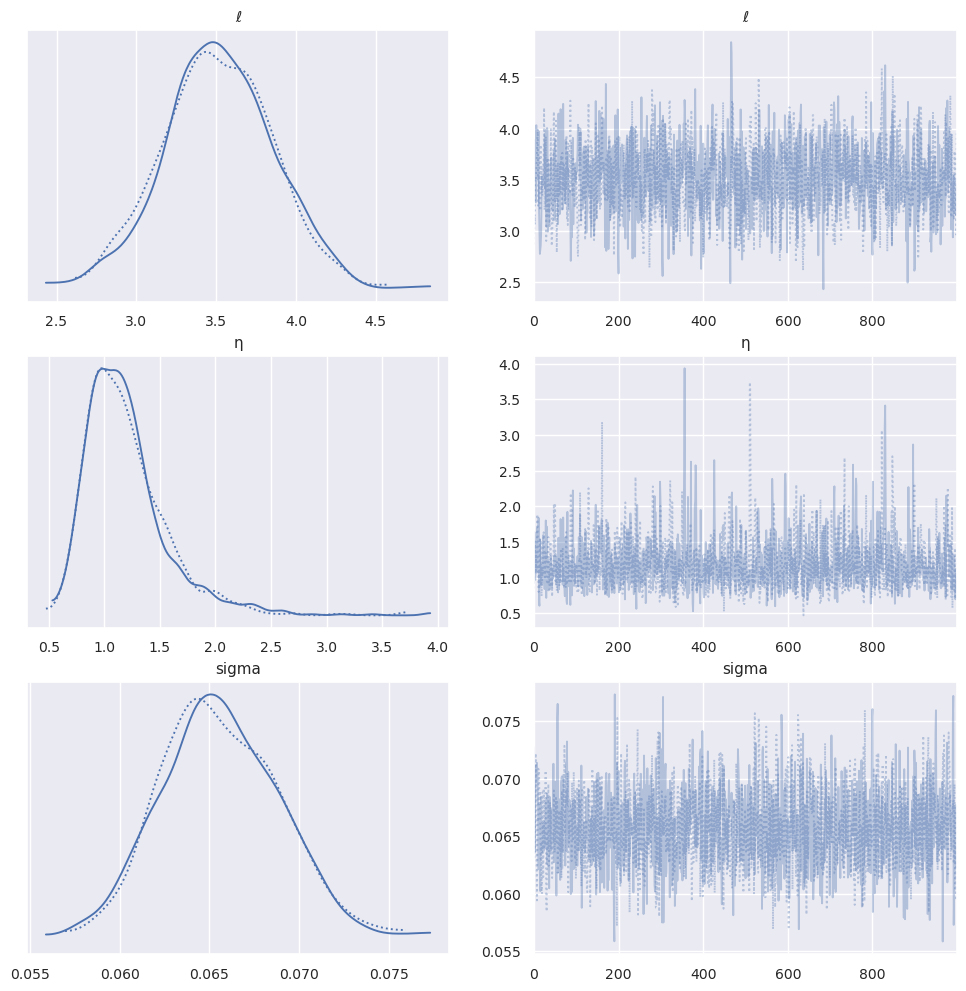

In [17]:
az.plot_trace(idata_pc, figsize=(12, 12))

pc_trace = plt.gcf()

figs["pc_trace"] = pc_trace

NameError: name 'y' is not defined

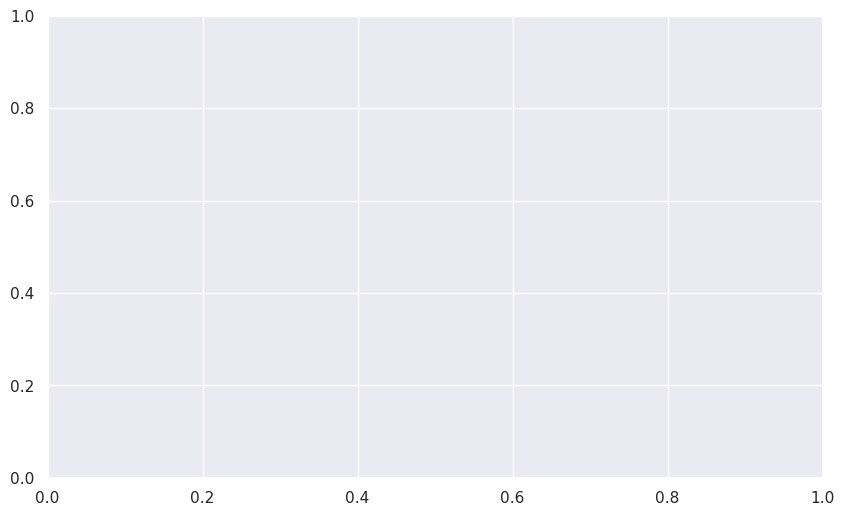

In [18]:
pc_pred, ax = plt.subplots(figsize=(10, 6))

y_pred = idata_pc.posterior_predictive.fnew.mean(["chain", "draw"])

ax.plot(Xnew, y_pred * y.std() + y.mean(), color="C0")
ax.scatter(X, y, s=3, color="C3")
az.plot_hdi(Xnew.flatten(), idata_pc.posterior_predictive.fnew * y.std() + y.mean())

ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")

figs["pc_pred"] = pc_pred

In [ ]:
if SAVE_FIGS:
    save_figs(figs)